In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 100 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.154238214520472
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 519.46it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 620.02it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
from earlystop import earlyStopper

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 5e-3
num_epochs = 200
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train_cost:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
              format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:   1.3616, Train Regret:  69.7561%, Val Regret:  58.3454%
Epoch  20, Loss:   0.2995, Train Regret:  33.7427%, Val Regret:  29.4310%
Epoch  40, Loss:   0.2439, Train Regret:  11.3140%, Val Regret:  14.0391%
Epoch  60, Loss:   0.2812, Train Regret:   8.8604%, Val Regret:  10.6886%
Epoch  80, Loss:   0.0611, Train Regret:   7.1995%, Val Regret:   9.2618%
Epoch 100, Loss:   0.0932, Train Regret:   7.7606%, Val Regret:   8.9384%
Epoch 120, Loss:   0.1674, Train Regret:   7.5147%, Val Regret:   9.2813%
Epoch 140, Loss:   0.0689, Train Regret:   7.5120%, Val Regret:   9.4146%
Epoch 160, Loss:   0.3059, Train Regret:   7.1744%, Val Regret:   9.7521%
Early Stop!
Elapsed Time: 1.02 Sec


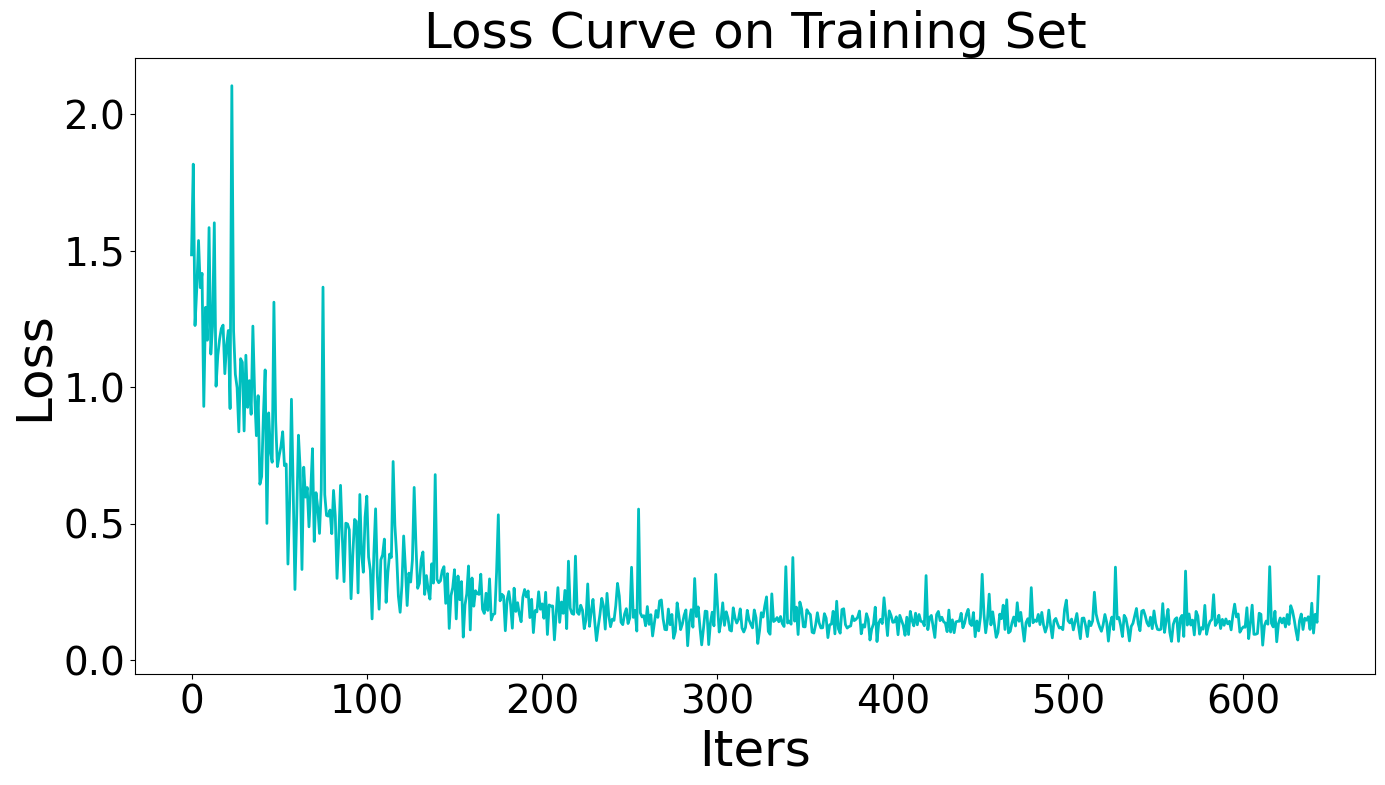

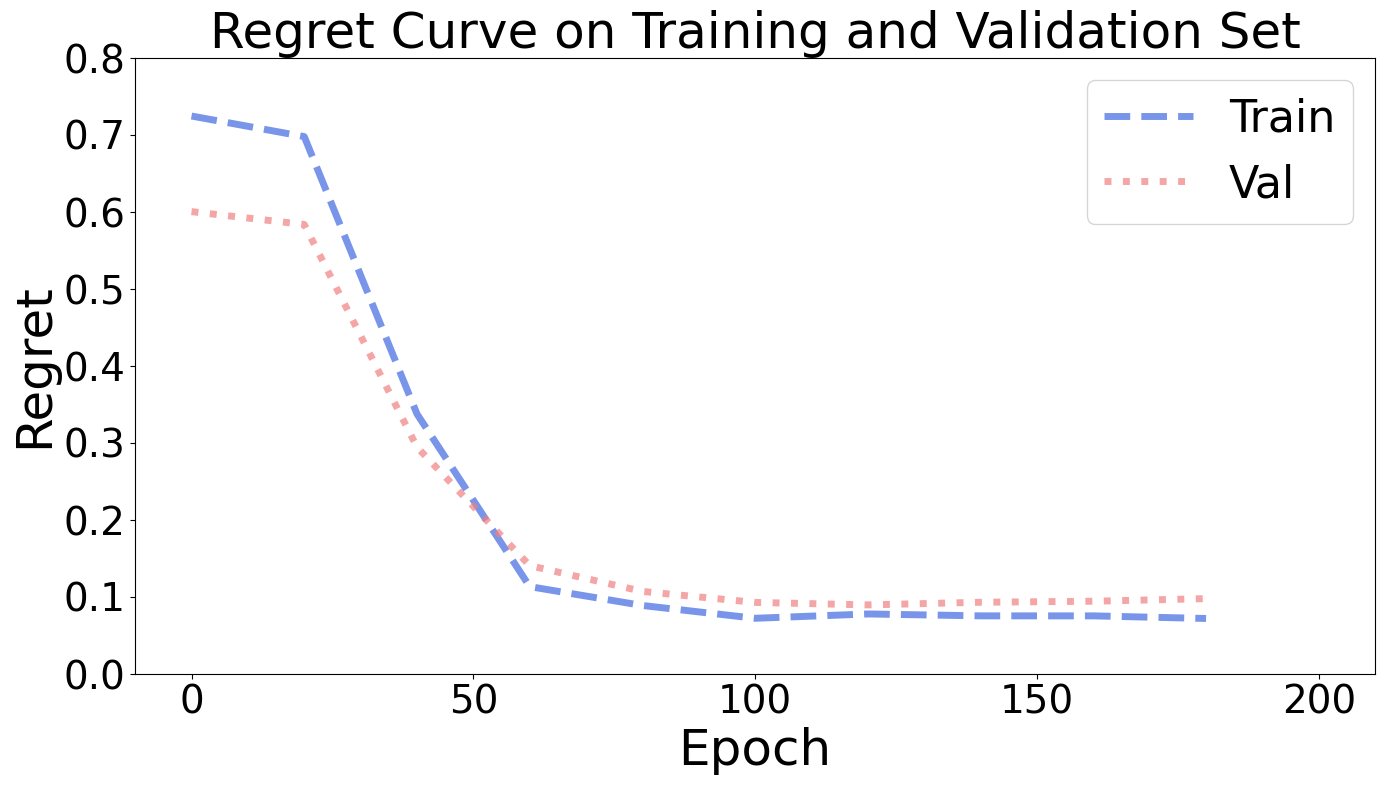

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [17]:
lr = 5e-3
num_epochs = 200
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9762, Train Regret:  53.8637%, Val Regret:  51.3171%
Epoch  20, Loss:  -0.9993, Train Regret:  21.2046%, Val Regret:  21.6123%
Epoch  40, Loss:  -0.9992, Train Regret:  16.1545%, Val Regret:  17.0970%
Epoch  60, Loss:  -1.0000, Train Regret:  17.2753%, Val Regret:  16.4551%
Epoch  80, Loss:  -0.9998, Train Regret:  15.8203%, Val Regret:  15.8762%
Epoch 100, Loss:  -0.9999, Train Regret:  15.0822%, Val Regret:  15.6675%
Epoch 120, Loss:  -0.9998, Train Regret:  16.1700%, Val Regret:  15.4200%
Epoch 140, Loss:  -0.9999, Train Regret:  13.3631%, Val Regret:  15.1744%
Epoch 160, Loss:  -0.9999, Train Regret:  12.9168%, Val Regret:  15.2865%
Epoch 180, Loss:  -1.0000, Train Regret:  14.5088%, Val Regret:  15.1697%
Elapsed Time: 132.90 Sec


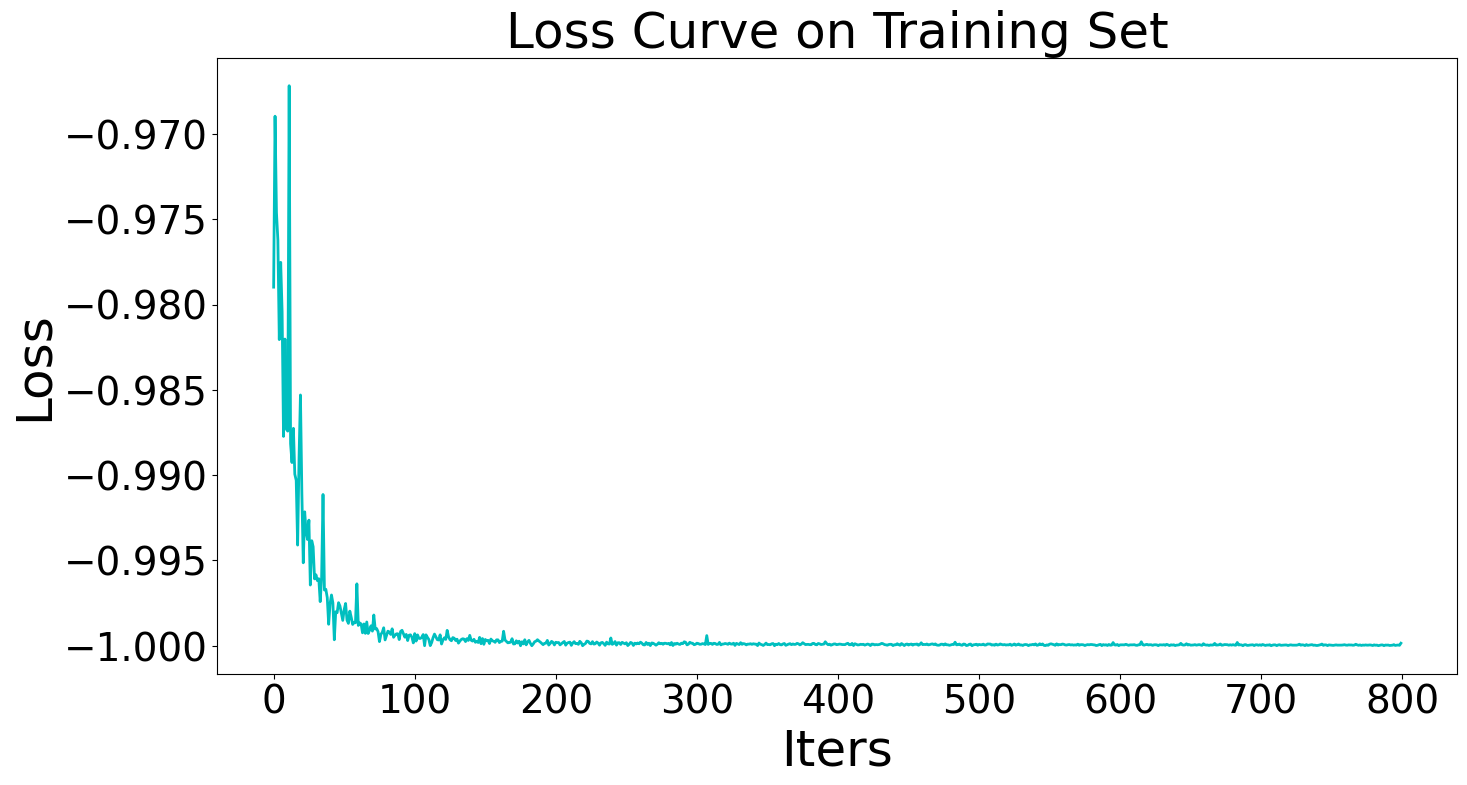

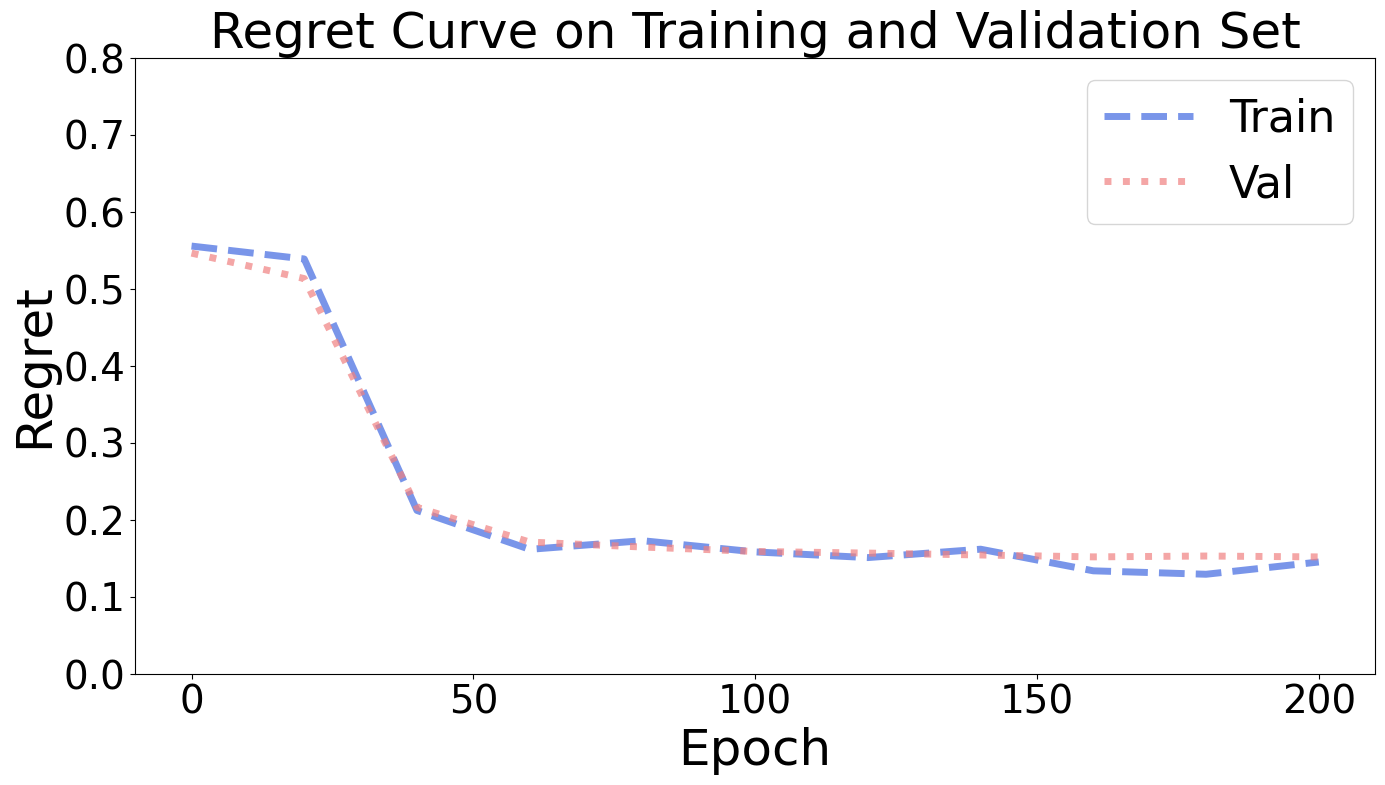

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [21]:
lr = 5e-3
num_epochs = 200
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.2560, Train Regret:  54.1099%, Val Regret:  52.7940%
Epoch  20, Loss:  -0.5919, Train Regret:  15.7956%, Val Regret:  19.6800%
Epoch  40, Loss:  -0.6622, Train Regret:  10.5577%, Val Regret:  13.3549%
Epoch  60, Loss:  -0.7004, Train Regret:   9.1583%, Val Regret:  11.7371%
Epoch  80, Loss:  -0.6759, Train Regret:   8.0365%, Val Regret:  11.2359%
Epoch 100, Loss:  -0.7078, Train Regret:   8.2357%, Val Regret:  11.3552%
Epoch 120, Loss:  -0.6743, Train Regret:   7.7227%, Val Regret:  11.3817%
Epoch 140, Loss:  -0.6809, Train Regret:   7.8269%, Val Regret:  11.2757%
Early Stop!
Elapsed Time: 3.63 Sec


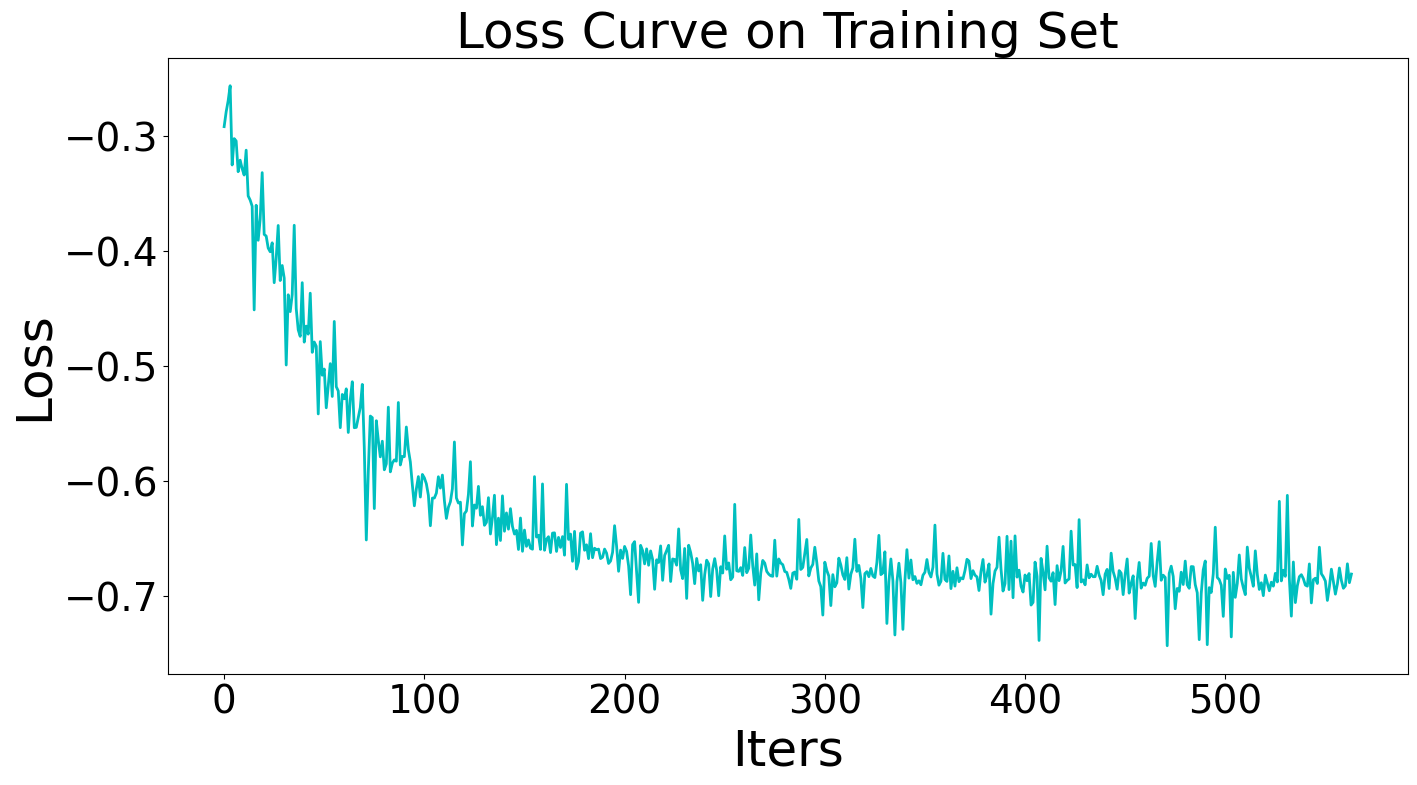

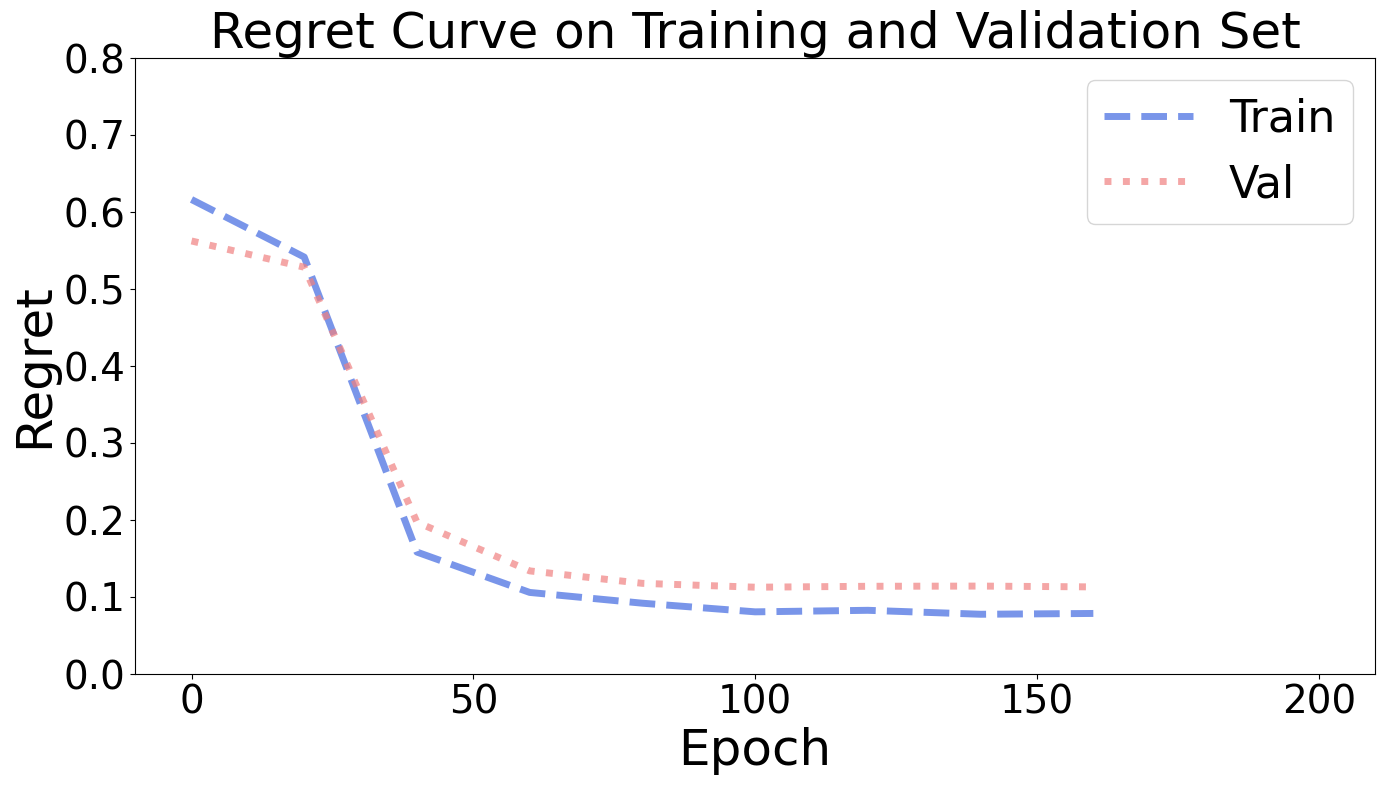

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [23]:
# init model
reg = LinearRegression()

In [24]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [25]:
lr = 5e-3
num_epochs = 200
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:   7.8889, Train Regret:  55.8323%, Val Regret:  44.4213%
Epoch  20, Loss:   3.1667, Train Regret:  10.2238%, Val Regret:  13.4255%
Epoch  40, Loss:   6.8333, Train Regret:   7.4178%, Val Regret:  10.4278%
Epoch  60, Loss:   4.4444, Train Regret:   4.6943%, Val Regret:   9.8547%
Epoch  80, Loss:   3.6667, Train Regret:   5.0621%, Val Regret:  10.2575%
Epoch 100, Loss:   2.8889, Train Regret:   4.6050%, Val Regret:   9.9794%
Epoch 120, Loss:   2.4444, Train Regret:   4.7103%, Val Regret:   9.4357%
Epoch 140, Loss:   3.2778, Train Regret:   5.2532%, Val Regret:   9.9451%
Epoch 160, Loss:   3.3889, Train Regret:   4.2305%, Val Regret:   9.9722%
Epoch 180, Loss:   3.2778, Train Regret:   4.0859%, Val Regret:  10.1084%
Early Stop!
Elapsed Time: 106.43 Sec


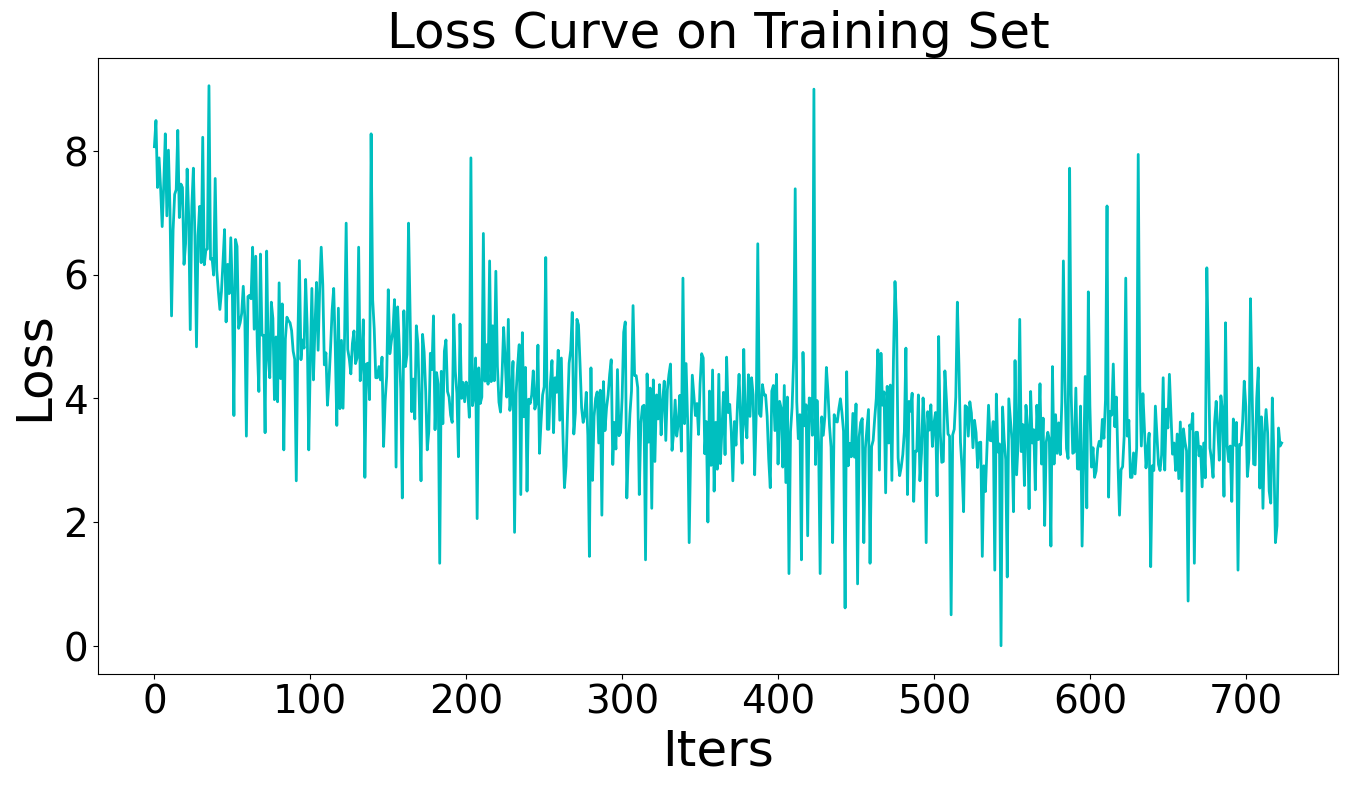

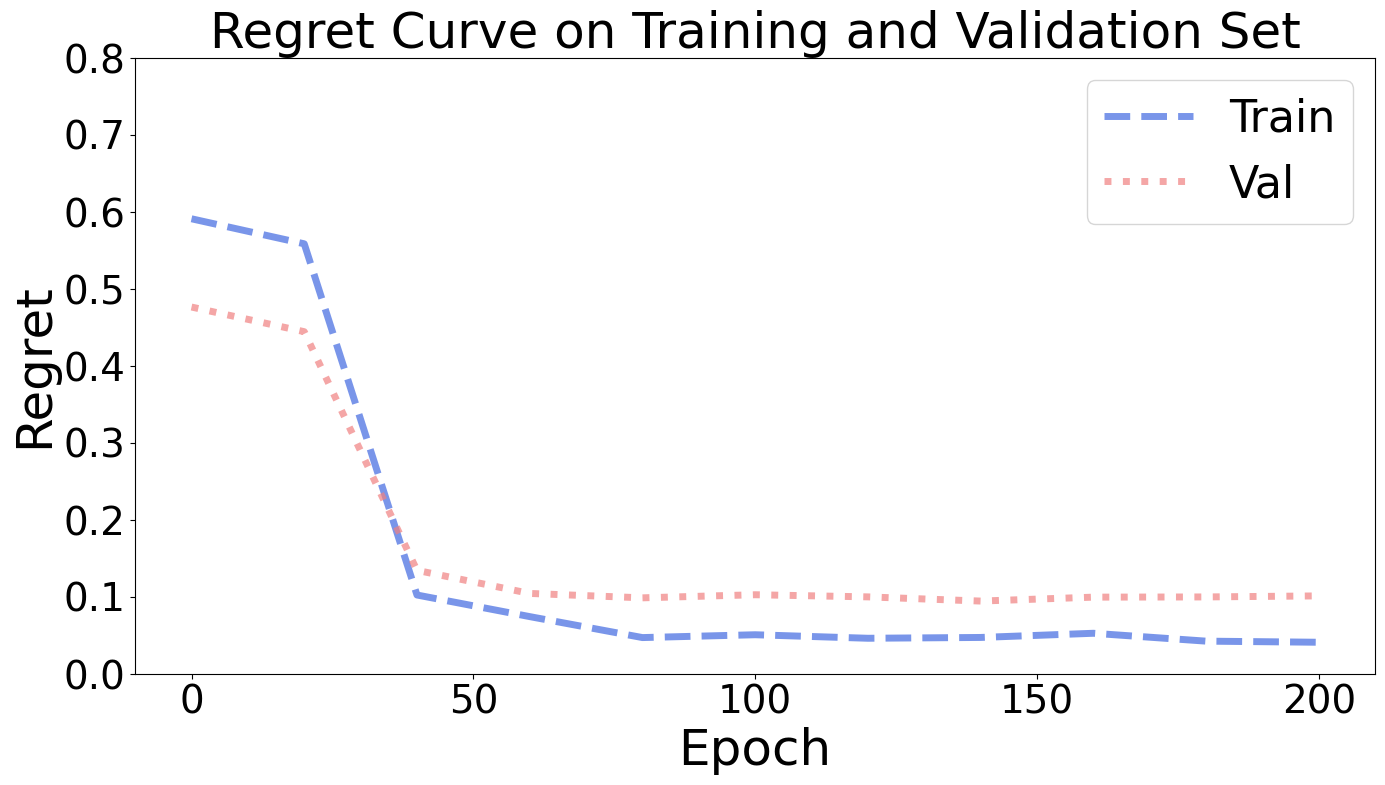

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)